#### In this notebook I will focus on clustering customers into segments based on their annual spending on a variety of products. 

In [1]:
import seaborn as sns
sns.set()

Clustering customers based on their behavior or other characteristics is a crucial aspect that allows a business to know their market, better tailor marketing efforts, and improve product development strategies. 

The data set containing wholesale customers purchasing information that contains data about customers' annual spending on different products.

In [2]:
import pandas as pd

df_wholesale = pd.read_csv('small_data/Wholesale_customers.csv')

In [3]:
df_wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,0,3,12669,9656,7561,214,2674,1338
1,0,3,7057,9810,9568,1762,3293,1776
2,0,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,0,3,22615,5410,7198,3915,1777,5185


The 'Channel' describes whether a customer is a hotel/restaurant/cafe or not and 'Region' describes where they are from. 

For the purpose of clustering our customers we will only focus on their spending habits, so we will only use information about customers annual spending (reported in euros) on fresh products, milk products, grocery, frozen products, detergents and paper products, and delicatessen products.

In [4]:
df_spending = df_wholesale.iloc[:, 2:]
df_spending.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


We want to get a general idea of what kinds of customers we have in this data. To do so, our plan will be to organize this data into groups, such that customers in the same group are more similar to one another than they are to customers in other groups. 

Then, we might see, for instance, that one group tends to buy a lot of milk products and not many detergents and paper products. Based on these preferences, we can obtain some insight into defining characteristics of our customer base.

#### K-Means clustering

K-Means is one of the simplest clustering algorithms which allows us to identify clusters of data points within our data. We define the number of clusters we want to find and the algorithm identifies which data points belong to each cluster based on similarity (or distance measured in feature space) between data points

We will first filter out any outliers from the data. Outliers are not such a big problem in this data set, but the results will improve if we make this the first step. We will import and use a function that detects outliers and filters them out. 

In [5]:
from pylib.outliers import filter_outliers

df_spending_cleaned = filter_outliers(df_spending)

In [6]:
print('Number of rows before cleaning: {}'.format(df_spending.shape[0]))
print('Number of rows after cleaning: {}'.format(df_spending_cleaned.shape[0]))

Number of rows before cleaning: 434
Number of rows after cleaning: 397


#### Scaling data

K-Means clustering uses the distance between points to define clusters. This means that all features should be scaled such that their units are comparable. Otherwise, certain features may seem artificially to have more variance than others.

In the case of the customers data set, all our features (annual spending on different products) are measured in the same units, so it could actually happen that scaling the data in this case would mean losing important information. This is something we need to be careful about and check. 

In this particular case it turns out that whether we scale the data with scikit-learn's StandardScaler transformer or not doesn't impact the results very much. We will scale the data here nevertheless, but again this step is even more important when dealing with features that are using units that are not comparable (for example customer income and customer age).

In [8]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

df_spending_cleaned_scaled = pd.DataFrame(standard_scaler.fit_transform(df_spending_cleaned),
                                          columns=df_spending_cleaned.columns)
df_spending_cleaned_scaled.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,0.155679,1.504403,0.285557,-0.783649,0.238210,0.101340
1,-0.389173,1.547533,0.666579,-0.274419,0.470146,0.440277
2,-0.457522,1.266906,0.308908,-0.062897,0.553703,5.135868
3,0.213542,-0.864959,-0.348530,1.252616,-0.573752,0.449563
4,1.121304,0.315241,0.216643,0.433833,-0.097891,3.078258


Clustering algorithms and metrics tend to be computationally complex, and this complexity scales very quickly with the number of features. As such, it is very common to reduce the dimensionality of the data before feeding into a K-Means clustering algorithm.

#### PCA 
While our customer data set does not have many features we will still reduce the dimensionality before we proceed, if nothing else so that we can visualize the results. I first perform PCA without throwing away any components, and plot the cumulative sum of the explained variance ratio so we can see how many components are required to explain a significant amount of the variation in the data.

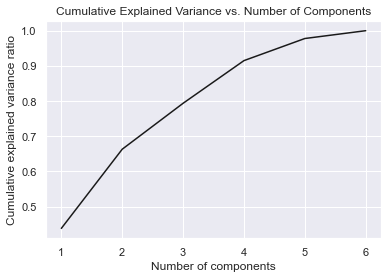

In [10]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=df_spending_cleaned_scaled.shape[1])

customers_pca_transformed = pca.fit_transform(df_spending_cleaned_scaled)

plt.plot(range(1, df_spending_cleaned_scaled.shape[1]+1), pca.explained_variance_ratio_.cumsum(), 'k')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance ratio")
plt.title("Cumulative Explained Variance vs. Number of Components");

It looks like we would need to use 4 components to capture 90% of the variance, but 3 components capture 80% and choosing 3 will lend itself to inspecting the results with a visualization. So let's use a PCA transformer that will project our data into 3D.

In [11]:
pca3D = PCA(n_components=3)

customers_pca_3D = pca3D.fit_transform(df_spending_cleaned_scaled)

#### Finding clusters

Now let's train a K-Means model on this data for a range of n_clusters values and compute the silhouette score for each model.

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for n_clusters in range(2, 9):
    km = KMeans(n_clusters=n_clusters)
    km.fit(customers_pca_3D)
    
    # Predict the cluster for each data point
    preds = km.predict(customers_pca_3D)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(customers_pca_3D, preds, metric='euclidean')
    print('For n_clusters = {}, the average silhouette_score is : {}'
          .format(n_clusters, score.round(5)))

For n_clusters = 2, the average silhouette_score is : 0.4406
For n_clusters = 3, the average silhouette_score is : 0.4163
For n_clusters = 4, the average silhouette_score is : 0.43308
For n_clusters = 5, the average silhouette_score is : 0.38215
For n_clusters = 6, the average silhouette_score is : 0.38182
For n_clusters = 7, the average silhouette_score is : 0.37757
For n_clusters = 8, the average silhouette_score is : 0.37231


It looks like there are probably 2 clusters in the data, but we could also choose 4. Let's see what we get for 4 clusters. We will visualize the results of a K-Means clustering model with 4 clusters by plotting the 3D data we obtained after the PCA transformation and color each data point according to the cluster it belongs to.

In [16]:
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import IntSlider
from ipywidgets import interact
from pylib.pml_plotting import plot_kmeans

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(customers_pca_3D)

cols = kmeans.predict(customers_pca_3D)
colors = ['#ba2121ff', '#42a5f5ff', '#efa016ff', '#000000ff']
centroids = kmeans.cluster_centers_

def plot_rotate(az, el):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.view_init(elev=el, azim=az)

    x = customers_pca_3D[:,0]
    y = customers_pca_3D[:,1]
    z = customers_pca_3D[:,2]
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3', rotation=90, labelpad=-2)

    ax.scatter(x, y, z, marker='o', s=4, color=[colors[col] for col in cols])

interact(plot_rotate, az=IntSlider(min=0, max=300, step=10, value=50, description='azimith'), 
                      el=IntSlider(min=0, max=90, step=10, value=20, description='elevation'));

interactive(children=(IntSlider(value=50, description='azimith', max=300, step=10), IntSlider(value=20, descri…

#### Interpreting cluster centroids

I found 4 clusters and each cluster has a centroid which corresponds to the average customer of that cluster. Because we scaled our data and used PCA on it before we fed it into a K-Means model, we need to apply inverse transformations to recover average customer information.

In [17]:
# Invert PCA
scaled_centers = pca3D.inverse_transform(centroids)

# Invert standard scaler
true_centers = standard_scaler.inverse_transform(scaled_centers)

In [18]:
typical_customers = pd.DataFrame(true_centers, columns=df_spending.columns, 
                                 index=['typical customer 1', 'typical customer 2', 
                                        'typical customer 3', 'typical customer 4'])
typical_customers

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
typical customer 1,4360.560233,8608.159429,13315.526102,1338.363598,5758.477607,1442.857783
typical customer 2,24836.416603,4670.331040,6092.015926,2313.515845,1264.348930,2814.533639
typical customer 3,13623.605869,3377.307370,3721.281035,9683.026771,547.755023,1283.453041
typical customer 4,9458.667704,2319.741725,3122.022565,1745.679418,840.258061,586.388622
